# COVID Dashboard

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

In [2]:
from src.phac import PHAC

can = PHAC()

In [3]:
def doubling_time(r):
    if r > 0:
        return f"doubling in {np.log(2) / np.log1p(r): .1f}"
    elif r == 0:
        return "stationary"
    else:
        return f"half life {-np.log(2) / np.log1p(r): .1f}"
    
def rate_to_dbl_in(nper):
    if nper == np.inf:
        return 0
    else:
        return np.expm1(np.log(2) / nper)
    
def zeros(ser):
    """
    Return the list of indices where a series intercepts the x-axis
    
    :param ser: pandas.Series
    """
    state = np.sign(ser[0])
    zeros = []
    for idx, val in ser.items():
        if np.sign(val) != state:
            if np.isnan(state):
                state = np.sign(val)
            else:
                zeros.append(idx)
                state = np.sign(val)
    return zeros

# Notes on Modeling COVID

## Introduction

The data sets available to us give us, for each location, a multi-dimensional timeseries.  Each time observation can be assumed to include the following features:

* $\tau_{t}$ - the nmber of individuals tested as a proportion of the population
* $\pi_{t}$ - the positivity rate.  Note $\pi \sim \frac{\nu}{\tau}$.  Depending on the reporting protocols, new cases reported at time $t$ may not be the result of tests reported at $t$.
* $\nu_{t}$ - the number of new cases as a proportion of the population
* $\delta_{t}$ - the number of deaths as a proportion of the population

We may also have

* $\rho_{t}$ the number of resolved cases as a proportion of the population
* $\eta_{t}$ the number of hospitalizations as a proportion of the population

Derived variables include:

* $T_{t} = \sum^{t}_{k=0}{\nu_{k}}$ - total cases as a proportion of the population

Note, the new cases reported at a give time, $t$, may not be the results of testing at $t$

## Processes driving disease spread

Viral spread is the result of the following processes:

* Transmission (or contagion) - this is a function of the virus
* Population immunity - this is a function of disease prgress and the state of vaccinations
* Exposure (or contact) - this is a function if population behaviour
* Resolution - this is a property of the virus and the treatment regime

### Exposure Model

We model exposure or contact by a random variable $E$ over $R_{\ge 0}$ where $P(E=x)$ is interpreted as the probability that a member of the population is exposed to viral load $x$.  The exponential distribution is a natural model for exposure. 

The exposure model varies with time and location and is affected by population behaviour.

Public health interventions aim to change population behaviour.

* Hand washing reduces exposure from fomites.
* Social distancing (maintaining distance from others) reduces exposure from droplets.
* Mask wearing reduces the amount of virus in the environment and reduces exposure from droplets in the air.  Note mask wearing may also increase exposure to fomites.
* Social isolation (reducing the number and duration of contacts) reduces exposure to the virus in all forms.  
* Testing, contact tracing, and quarantine aim to isolate eliminate reduce the viral load in social environments.
* Facility controls (e.g, ventilation) reduce viral load in environment

If we choose the exponential distribution, then the p.d.f is $P(E=x) = \lambda e^{-\lambda x)}$ and the c.d.f is $P(E \le x) = (1 - e^{-\lambda x})$

So exposure model is parameterized by a series $\{\lambda^E_t\}$ for each location.

### Transmission (Contagion Model)

We model transmission as a mixture of exponential distributions.  Only the latent mixture variable changes with time.  We have a set of strains $S$ and a family $\{C_s | s \in S\}$ of exponential distributions.  Each $C_s$ represents the pobability that a susceptible member of the population is infected when exposed to a viral load $x$. (Note, we may want to consider using a logistic distribution if infection has a hard threshold).  At any point in time we has a distribution $P_t(S=s) = p_t(s)$.

So the transmission model is parameterized by $\{\lambda^S_s\}$ and $|S|$-wide series $<p_t(s)>$ at each location

### Immunity Model


### Resolution Model.

Infections resolve after a period of time.  Either the infected individual recovers and is no longer infectious or the infected individual dies and is no longer infectious.  We assume that resolution is independent of time and virus strain.  Resolution can be assumed to follow a poisson distribution $r(n;\lambda)$ representing the probability that a case resolves after $n$ time periods. Let $Res$ be the random variable representing the resolution model.

## Growth Model for a Single Location

Transmission rate at time $t$ is given by

$$ R_t = \sum_{s \in S}{p_t(s) \int_{x}{P_t(E=x) P(C_s=x)} dx} = \sum_{s \in S}{ p_t(s) \frac{\lambda^E_t \lambda^S_s}{\lambda^E_t + \lambda^S_s} }$$

Let $\alpha_t(k)$ be the active cases of age $k$ at time $t$ as a proportion of the population, and let $\alpha_t = \sum_{k}{\alpha_t(k)}$.  We have,

$$\alpha_{t+1}(k+1) = \alpha_t(k) Prob(Res > k) \text{ and } \alpha_{t+1}(0) = \alpha_t R_t$$
 



## Estimating True Incidence

Let $\eta_t$ be the incidence rate (proportion of the population) infected at time $t$.  


In [4]:
fit_win = 14
meas_win = 7
tests = can.var_by_location("new_tests_rate", *can.provinces, ma_window=1)*1000
cases = can.var_by_location("new_cases_rate", *can.provinces, ma_window=1)
deaths = can.var_by_location("new_deaths_rate", *can.provinces, ma_window=meas_win).fillna(0)
posrate = can.pos_test_rate(meas_win, *can.provinces)
posgrowth = can.growth_rate("pos_test_rate", meas_win, *can.provinces)

/Users/bill/IdeaProjects/covid-19/src/dataset.py:150: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


In [39]:
pt_1day = can.pos_test_rate(1, *can.provinces)
100 * pt_1day[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2021-04-25,8.099425,8.132501,5.780377,8.298622,0.428725,0.318979,0.000000,0.796460,4.216867,7.567101,0.000000,2.679775,7.274321,0.00
2021-04-26,8.779657,7.078579,6.020511,6.720257,0.928382,0.610687,2.564103,0.877660,4.687500,7.517026,0.394477,3.050057,7.847534,6.25
2021-04-27,10.365032,9.701311,6.796593,7.383242,2.205882,0.000000,0.000000,0.846934,5.063291,9.653480,0.000000,3.268615,7.818499,0.00
2021-04-28,13.381358,9.783620,7.120018,6.401917,0.352578,0.700525,0.000000,0.752861,4.477612,10.235294,0.216685,3.399416,6.266549,0.00
2021-04-29,10.792580,7.618112,5.490477,6.011221,0.827815,0.228833,0.000000,0.475221,10.169492,7.712077,0.000000,2.233272,6.352087,0.00
2021-04-30,9.751239,6.780282,5.411473,8.006672,0.977199,1.523810,0.000000,0.522539,7.142857,6.826604,0.234742,2.467819,6.996936,0.00
2021-05-01,12.835663,0.000000,5.060793,4.702032,0.885827,0.538793,0.000000,1.095972,4.494382,6.347741,0.000000,2.685890,6.794606,0.00


In [6]:
tests[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2021-04-25,4.012321,2.023225,3.563741,2.262804,1.193897,1.200901,5.602369,8.076830,4.218224,3.540102,5.268505,4.412937,2.904090,0.261580
2021-04-26,3.850852,2.093943,3.148017,2.254826,0.964860,1.254553,2.590747,7.678633,4.878910,3.169133,3.176054,3.399234,2.648723,0.380484
2021-04-27,3.357854,1.599935,2.736678,2.111273,1.392258,1.030457,0.819296,11.573982,4.014941,2.295507,4.034278,3.207626,2.430680,0.499385
2021-04-28,3.107953,1.669871,2.863662,2.117800,2.903480,1.093631,2.856465,10.172116,3.405086,2.307589,5.782415,3.753194,2.883735,0.118901
2021-04-29,4.291391,2.175145,3.998241,2.713768,1.545795,1.674021,3.343614,15.040828,2.998500,3.406677,4.942931,5.441440,2.804828,0.237802
2021-04-30,4.654588,2.120164,4.055148,2.607913,1.964239,1.005551,1.926453,13.092493,3.913291,3.864460,5.337474,4.919547,3.322359,0.261583
2021-05-01,4.286642,2.000500,3.960238,4.209488,2.600182,1.777451,2.524318,13.788764,4.523158,3.602136,4.617040,4.780648,3.271456,0.856089


In [23]:
location = "Ontario"

In [24]:
from src.models.growth import GeometricProcess

proc = GeometricProcess(est_per=fit_win)
proc.fit(posrate[location])

# Get sign changes in growth rate
grzeros = zeros(proc.model["LogGrowthRate"])

x = [idx.date() for idx in proc.model.index]
x_shifted = proc.model.index - proc.est_per * pd.Timedelta("1 day")

model = np.exp(proc.model)
model.columns = ["Growth Rate", "Prior Positivity Rate", "Error", "Predicted Positivity Rate", "Measured Positivity Rate"]
model[-14:]

,Growth Rate,Prior Positivity Rate,Error,Predicted Positivity Rate,Measured Positivity Rate
2021-04-18,1.030895,0.053916,1.011819,0.080077,0.078438
2021-04-19,1.027749,0.056669,1.012683,0.080887,0.079088
2021-04-20,1.024848,0.059273,1.013998,0.081551,0.079612
2021-04-21,1.021668,0.062010,1.013276,0.081940,0.080091
2021-04-22,1.017612,0.064975,1.014618,0.081530,0.077784
2021-04-23,1.014275,0.067652,1.011704,0.081340,0.079356
2021-04-24,1.011693,0.069920,1.008481,0.081327,0.080407
2021-04-25,1.009440,0.071936,1.005572,0.081283,0.080618
2021-04-26,1.007655,0.073454,1.005590,0.081110,0.079556
2021-04-27,1.006738,0.074505,1.005257,0.081301,0.081093


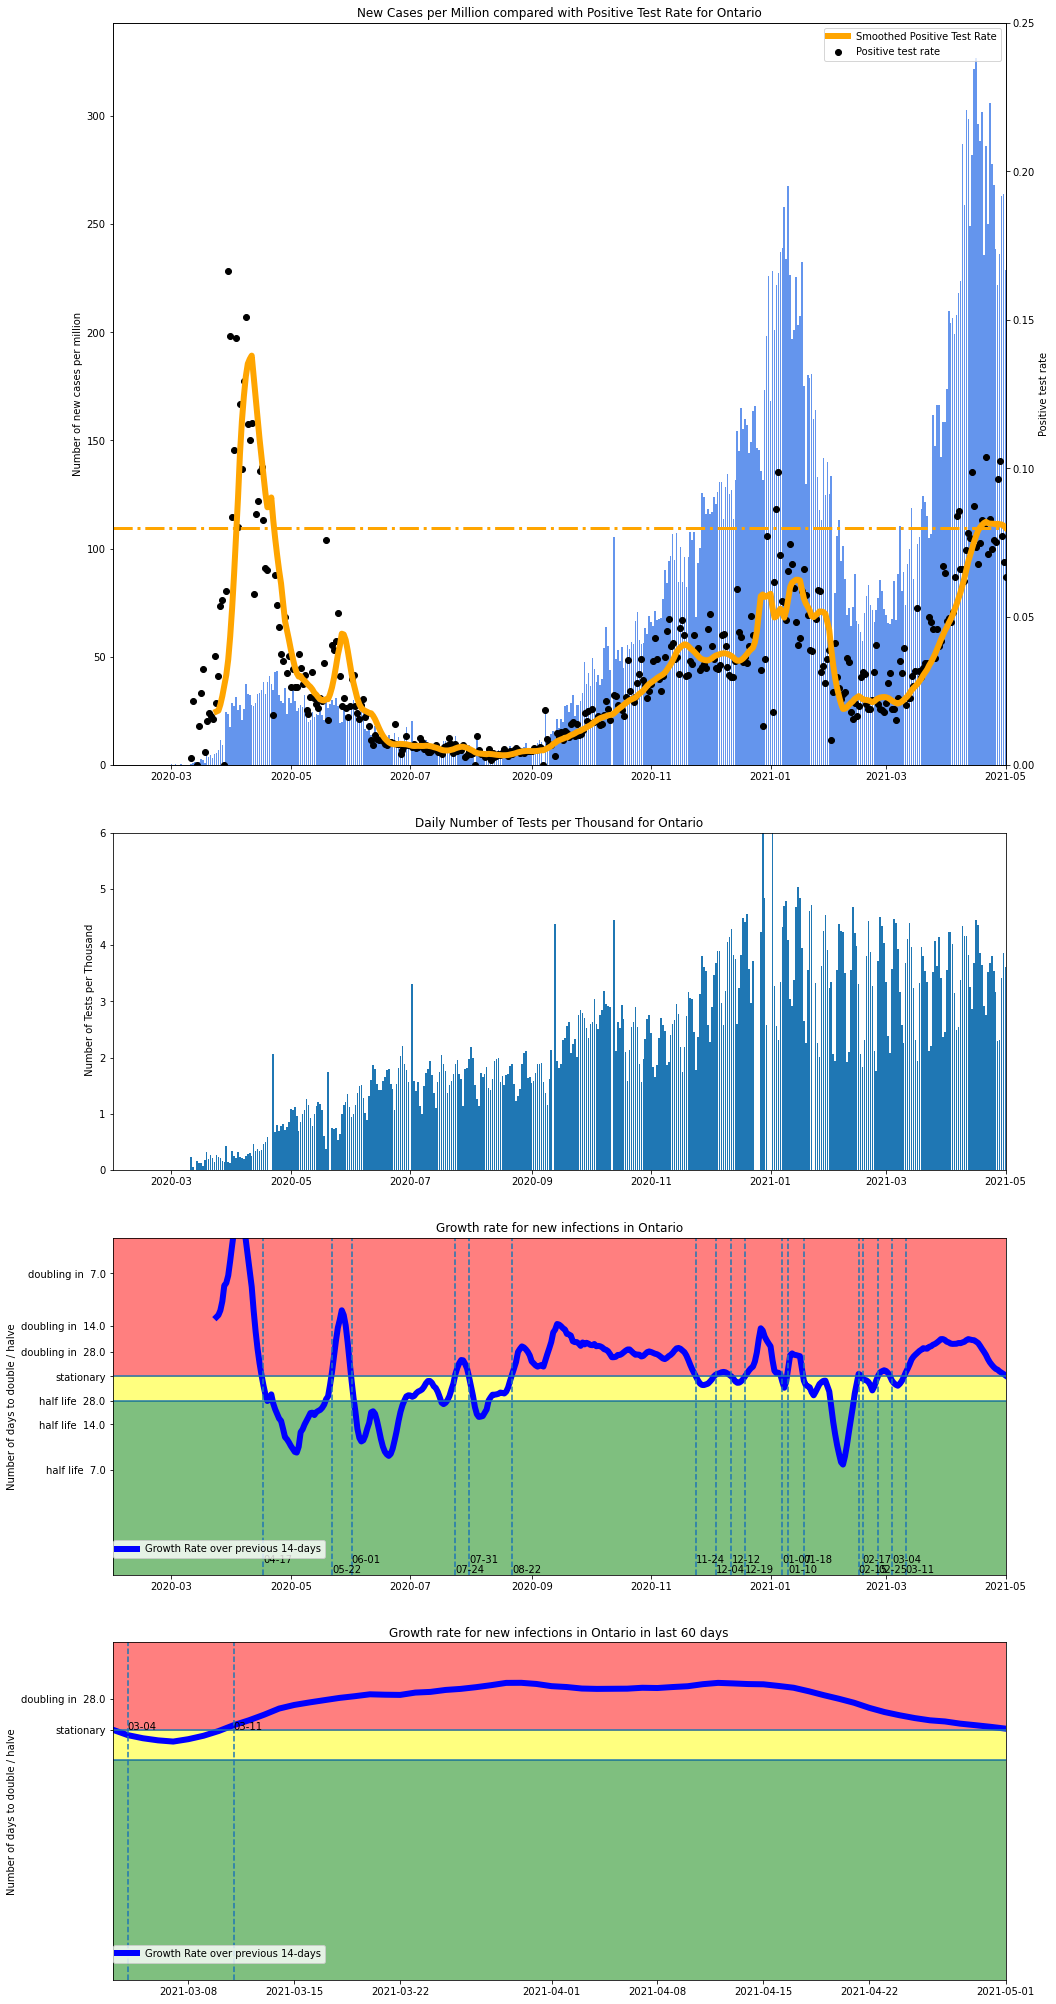

In [25]:
save_file = True
    
doubling_ticks = [-2, -3, -4, -5, -6, -7, -14, -28, np.inf, 28, 14, 7, 6, 5, 4, 3, 2]
doubling_tick_locs = [rate_to_dbl_in(nper) for nper in doubling_ticks]
doubling_tick_labels = [doubling_time(tick) for tick in doubling_tick_locs]
doubling_hlines = [rate_to_dbl_in(nper) for nper in [-28, np.inf]]


#dashboard, db_ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16,24))
dashboard = plt.figure(figsize=(16,36))
db_ax = []
gs = GridSpec(5,1, figure=dashboard)
db_ax.append(dashboard.add_subplot(gs[0:2,:]))
db_ax.append(dashboard.add_subplot(gs[3,:]))
db_ax.append(dashboard.add_subplot(gs[2,:]))
db_ax.append(dashboard.add_subplot(gs[4,:]))

db_ax[0].bar(cases.index, cases[location]*1000000, color="cornflowerblue")
#db_ax[0].plot(cases.index, deaths[location], color="black")
db_ax[0].set_ylabel(f"Number of new cases per million")
db_ax0r = db_ax[0].twinx()
db_ax0r.plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="orange", lw=6, label="Smoothed Positive Test Rate")
db_ax0r.scatter(pt_1day.index, pt_1day[location], 
                c="black", label=f"Positive test rate" )
db_ax0r.set_ylim((0, 0.25))
db_ax0r.set_ylabel("Positive test rate")
db_ax[0].set_xlim((min(cases.index), max(cases.index)))
db_ax[0].set_title(f"New Cases per Million compared with Positive Test Rate for {location}")
db_ax0r.legend()

db_ax0r.axhline(y=np.exp(proc.model.iloc[-1]["PredictedLogValue"]), lw=3, linestyle="-.", c="orange")

#db_ax[1].plot(posgrowth.index, posgrowth[location], lw=6, label="Growth Rate")
#posgrowth_ma = posgrowth.rolling(14).mean()[location]
#db_ax[1].plot(posgrowth.index, posgrowth_ma, lw=6, c="orange", label="14-day moving average")
db_ax[1].plot(x, np.exp(proc.model["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[1].set_xlim((min(cases.index), max(cases.index)))
db_ax[1].set_ylim( (-0.2, 0.14))
db_ax[1].set_yticks(doubling_tick_locs[5:-5])
db_ax[1].set_yticklabels(doubling_tick_labels[5:-5])
db_ax[1].set_ylabel("Number of days to double / halve")
db_ax[1].set_title(f"Growth rate for new infections in {location}")
db_ax[1].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[1].axhline(y=y)

db_ax[1].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[1].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[1].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

# if location == "Ontario":
#     db_ax[1].axvline(x="2020-05-19", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 1  \nopening begins  ", 
#                       ("2020-05-19", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-06-12", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 2  \nopening begins  ", 
#                       ("2020-06-12", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-07-17", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 3  \nopening begins  ", 
#                       ("2020-07-17", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-09-23", linestyle="-", lw=6)
#     db_ax[1].annotate("Bars and restaurants  \nordered to close early  ", 
#                       ("2020-09-23", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-10-14", linestyle="-", lw=6)
#     db_ax[1].annotate("Modified Phase 2  \nPeel, Toronto, Ottawa  ", 
#                       ("2020-10-14", 0.075),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-12-26", linestyle="-", lw=6)
#     db_ax[1].annotate("Province Wide Lock Down", 
#                       ("2020-12-26", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2021-01-13", linestyle="-", lw=6)
#     db_ax[1].annotate("Emergency Stay at Home Order", 
#                       ("2021-01-13", 0.075),
#                      horizontalalignment="right")



anpos = 1
for idx in grzeros:
    db_ax[1].axvline(x=idx, linestyle="--")
    db_ax[1].annotate(str(idx.date())[-5:], (idx, 0.002 + db_ax[1].get_ylim()[0] + anpos * 0.01))
    anpos = (anpos + 1) % 2

db_ax[2].bar(tests.index, tests[location])
db_ax[2].set_title(f"Daily Number of Tests per Thousand for {location}")
db_ax[2].set_ylabel(" Number of Tests per Thousand")
db_ax[2].set_xlim((min(tests.index), max(tests.index)))
db_ax[2].set_ylim((0, 6))

# zoom in on growth rate
zoom = 60
db_ax[3].plot(x[-zoom:], np.exp(proc.model[-zoom:]["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[3].set_xlim( ( min(x[-zoom:]), max(x[-zoom:]) ) )
db_ax[3].set_ylim( (-0.2, 0.07))
db_ax[3].set_yticks(doubling_tick_locs[8:-7])
db_ax[3].set_yticklabels(doubling_tick_labels[8:-7])
db_ax[3].set_ylabel("Number of days to double / halve")
db_ax[3].set_title(f"Growth rate for new infections in {location} in last {zoom} days")
db_ax[3].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[3].axhline(y=y)

db_ax[3].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[3].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[3].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

for idx in grzeros:
    if idx in x[-zoom:]:
        db_ax[3].axvline(x=idx, linestyle="--")
        db_ax[3].annotate(str(idx.date())[-5:], (idx, 0))

    


if save_file:
    as_of = x[-1]
    savefile = f"{as_of}_COVID_Dashboard_{location}.png"
    plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile), format="png")




In [26]:
ptr = list(map(doubling_time, np.exp(proc.model["LogGrowthRate"])-1))
ptr[-10:]

['doubling in  39.7',
 'doubling in  48.9',
 'doubling in  59.6',
 'doubling in  73.8',
 'doubling in  90.9',
 'doubling in  103.2',
 'doubling in  139.4',
 'doubling in  185.0',
 'doubling in  282.2',
 'doubling in  693.1']

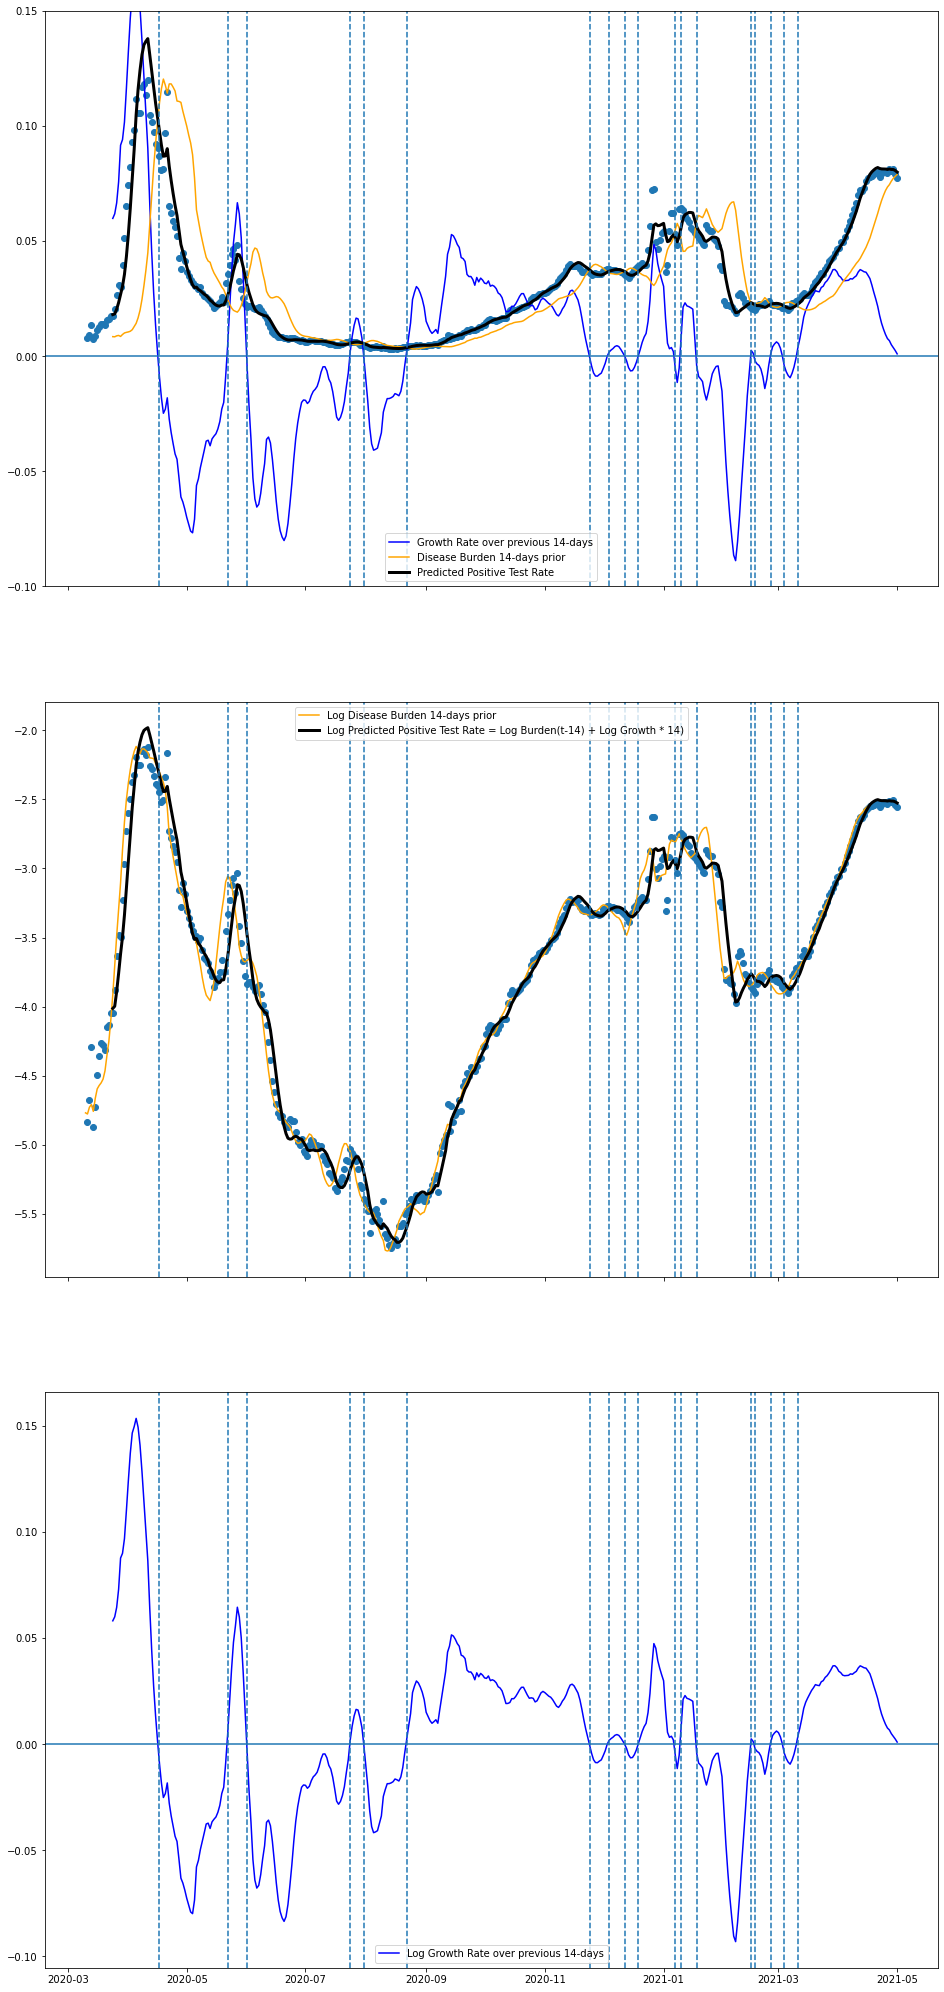

In [27]:
f1, ax1 = plt.subplots(nrows=3, ncols=1, figsize=(16,36), sharex=True)

ax1[0].plot(x, np.exp(proc.model["LogGrowthRate"])-1, 
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
ax1[0].plot(x, np.exp(proc.model["LogPriorProcessLoad"]), 
         c="orange", label=f"Disease Burden {fit_win}-days prior")
ax1[0].plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="black", lw=3, label="Predicted Positive Test Rate")
ax1[0].scatter(posrate.index, posrate[location] )
ax1[0].set_ylim((-0.1, 0.15))
ax1[0].legend()

for idx in grzeros:
    ax1[0].axvline(x=idx, linestyle="--")
ax1[0].axhline(y=0)

#ax1[1].plot(posrate.index[x], [fit[0][0] for fit in fits], c="blue", label="Log Growth Rate")
ax1[1].plot(x_shifted, proc.model["LogPriorProcessLoad"], 
         c="orange", label=f"Log Disease Burden {fit_win}-days prior")
ax1[1].plot(x, proc.model["PredictedLogValue"], 
         c="black", lw=3, 
         label=f"Log Predicted Positive Test Rate = Log Burden(t-{fit_win}) + Log Growth * {fit_win})")
ax1[1].scatter(posrate.index, np.log(posrate[location]) )
#ax1[1].set_ylim((-0.1, 0.1))
ax1[1].legend()

for idx in grzeros:
    ax1[1].axvline(x=idx, linestyle="--")

ax1[2].plot(x, proc.model["LogGrowthRate"], 
            c="blue", label=f"Log Growth Rate over previous {fit_win}-days")
#ax1[2].plot(x, lgr, 
#            c="red", label=f"Log Growth Rate Core Processes")
ax1[2].legend()

ax1[2].axhline(y=0)
for idx in grzeros:
    ax1[2].axvline(x=idx, linestyle="--")

In [28]:
ont = pd.read_csv("https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv")

In [29]:
ont

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-03-16,2020-03-26,2020-03-26,2020-03-18,20s,FEMALE,TRAVEL,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-03-18,2020-03-26,2020-03-26,2020-03-22,60s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-03-21,2020-03-26,2020-03-26,2020-03-22,60s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-03-22,2020-03-26,2020-03-26,2020-03-22,70s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-03-20,2020-03-26,2020-03-26,2020-03-22,80s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470460,470461,2020-03-29,2020-04-02,2020-04-02,2020-04-01,40s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
470461,470462,2020-05-21,2020-05-23,2020-05-23,2020-05-22,60s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
470462,470463,2020-04-08,2020-04-15,2020-04-15,2020-04-13,50s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
470463,470464,2020-04-01,2020-04-05,2020-04-05,2020-04-04,20s,MALE,CC,Resolved,NaN,2236,Halton Region Health Department,1151 Bronte Road,Oakville,L6M 3Ll,www.halton.ca/For-Residents/Public-Health/,43.413997,-79.744796


In [30]:
ont.columns

Index(['Row_ID', 'Accurate_Episode_Date', 'Case_Reported_Date',
       'Test_Reported_Date', 'Specimen_Date', 'Age_Group', 'Client_Gender',
       'Case_AcquisitionInfo', 'Outcome1', 'Outbreak_Related',
       'Reporting_PHU_ID', 'Reporting_PHU', 'Reporting_PHU_Address',
       'Reporting_PHU_City', 'Reporting_PHU_Postal_Code',
       'Reporting_PHU_Website', 'Reporting_PHU_Latitude',
       'Reporting_PHU_Longitude'],
      dtype='object')

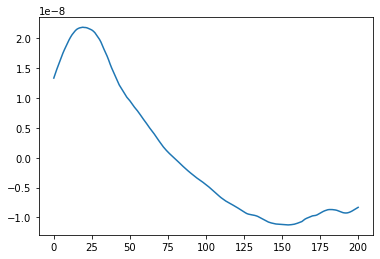

In [31]:
   

def cross_cov(s1,s2):
    """
    Return the cross covariance of s1 and s2
    """
    
    n = len(s1)
    max_lag = n // 2
    x1 = s1.values; m1 = np.mean(x1)
    x2 = s2.values; m2 = np.mean(x2)
    result = []
    for h in range(max_lag):
        result.append(
            sum([(x1[t] - m1) * (x2[t-h] - m2) for t in range(h,n)]) / n
        )
    return result

ccv = cross_cov(deaths[31:][location], posrate[31:][location])
plt.plot(range(len(ccv)), ccv)
        

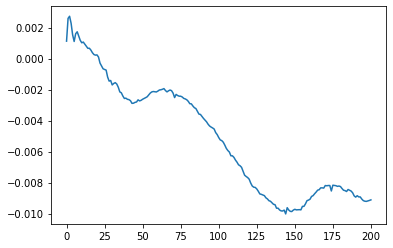

In [32]:
ccv = cross_cov(tests[31:][location], posrate[31:][location])
plt.plot(range(len(ccv)), ccv)
        

In [33]:
acv_matrix = np.cov(posrate[31:])
acv_matrix

/Users/bill/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


array([[ 3.70413489e-04,  4.28699758e-04,  3.83752736e-04, ...,
        -1.42884155e-04, -1.24211535e-04, -1.27824151e-04],
       [ 4.28699758e-04,  5.07948387e-04,  4.42720367e-04, ...,
        -1.52606717e-04, -1.28668215e-04, -1.31735676e-04],
       [ 3.83752736e-04,  4.42720367e-04,  4.10413031e-04, ...,
        -9.33684394e-05, -8.57161994e-05, -9.42921853e-05],
       ...,
       [-1.42884155e-04, -1.52606717e-04, -9.33684394e-05, ...,
         1.20301759e-03,  1.20645028e-03,  1.17916680e-03],
       [-1.24211535e-04, -1.28668215e-04, -8.57161994e-05, ...,
         1.20645028e-03,  1.24399796e-03,  1.22311355e-03],
       [-1.27824151e-04, -1.31735676e-04, -9.42921853e-05, ...,
         1.17916680e-03,  1.22311355e-03,  1.21610848e-03]])

In [34]:
cases[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2021-04-25,0.000325,0.000165,0.000206,0.000188,0.000005,0.000004,0.000000,0.000064,0.000178,0.000268,0.000000,0.000118,0.000211,0.000000
2021-04-26,0.000338,0.000148,0.000190,0.000152,0.000009,0.000008,0.000066,0.000067,0.000229,0.000238,0.000013,0.000104,0.000208,0.000024
2021-04-27,0.000348,0.000155,0.000186,0.000156,0.000031,0.000000,0.000000,0.000098,0.000203,0.000222,0.000000,0.000105,0.000190,0.000000
2021-04-28,0.000416,0.000163,0.000204,0.000136,0.000010,0.000008,0.000000,0.000077,0.000152,0.000236,0.000013,0.000128,0.000181,0.000000
2021-04-29,0.000463,0.000166,0.000220,0.000163,0.000013,0.000004,0.000000,0.000071,0.000305,0.000263,0.000000,0.000122,0.000178,0.000000
2021-04-30,0.000454,0.000144,0.000219,0.000209,0.000019,0.000015,0.000000,0.000068,0.000280,0.000264,0.000013,0.000121,0.000232,0.000000
2021-05-01,0.000550,0.000000,0.000200,0.000198,0.000023,0.000010,0.000000,0.000151,0.000203,0.000229,0.000000,0.000128,0.000222,0.000000


In [35]:
new_cases_abs = can.var_by_location("new_cases", *can.provinces)
new_cases_abs[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2021-04-25,1437.0,847.0,7829.0,259.0,4.0,2.0,0.0,63.0,7.0,3947.0,0.0,1014.0,249.0,0.0
2021-04-26,1495.0,763.0,7203.0,209.0,7.0,4.0,3.0,66.0,9.0,3510.0,2.0,889.0,245.0,1.0
2021-04-27,1539.0,799.0,7069.0,215.0,24.0,0.0,0.0,96.0,8.0,3265.0,0.0,899.0,224.0,0.0
2021-04-28,1839.0,841.0,7749.0,187.0,8.0,4.0,0.0,75.0,6.0,3480.0,2.0,1094.0,213.0,0.0
2021-04-29,2048.0,853.0,8343.0,225.0,10.0,2.0,0.0,70.0,12.0,3871.0,0.0,1042.0,210.0,0.0
2021-04-30,2007.0,740.0,8340.0,288.0,15.0,8.0,0.0,67.0,11.0,3887.0,2.0,1041.0,274.0,0.0
2021-05-01,2433.0,0.0,7617.0,273.0,18.0,5.0,0.0,148.0,8.0,3369.0,0.0,1101.0,262.0,0.0


In [36]:
import urllib.request as urllib
import json

url = 'https://data.ontario.ca/api/3/action/datastore_search?resource_id=455fd63b-603d-4608-8216-7d8647f43350'  
fileobj = urllib.urlopen(url)
data = json.loads(fileobj.read())
data

{'help': 'https://data.ontario.ca/api/3/action/help_show?name=datastore_search',
 'success': True,
 'result': {'include_total': True,
  'resource_id': '455fd63b-603d-4608-8216-7d8647f43350',
  'fields': [{'type': 'int', 'id': '_id'},
   {'info': {'notes': '', 'type_override': 'numeric', 'label': ''},
    'type': 'numeric',
    'id': 'Row_ID'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Accurate_Episode_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Case_Reported_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Test_Reported_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Specimen_Date'},
   {'info': {'notes': '', 'type_override': '', 'label': ''},
    'type': 'text',
    'id': 'Age_Group'},
   {'info': {'notes': '', 'type_overrid

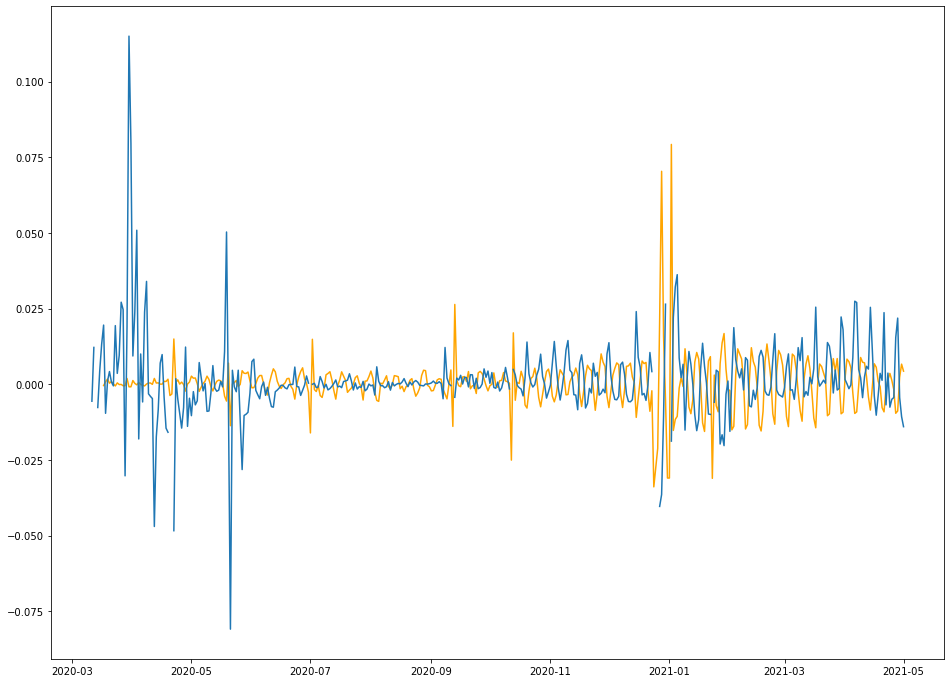

In [37]:
adj_tests = (tests - tests.rolling(7).mean()) / 1000

on_adj_tests = adj_tests["Ontario"]
on_pt = pt_1day["Ontario"]
on_adj_pt = on_pt - posrate["Ontario"]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,12))

ax.plot(on_adj_tests.index, 10 * on_adj_tests.values, c="orange")
#axr = ax.twinx()
ax.plot(on_pt.index, on_adj_pt.values)

In [38]:
can.plot_var("new_tests_per_thousand", "Ontario", figsize=(16,12), ma_window=28)

AttributeError: 'NotImplementedType' object has no attribute 'index'

In [ ]:
data = np.empty((len(on_pt),2))
data[:,0] = on_adj_tests.values
data[:,1] = on_adj_pt.values
data.shape

In [ ]:
cov_img = np.ma.cov(np.ma.array(data.T, mask=(np.isnan(data.T))))
cov_img

In [ ]:
data

In [ ]:
dateparse = lambda x: datetime.date(*time.strptime(x, '%d-%m-%Y')[:3])
src = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19.csv",
                         error_bad_lines=False,
                         warn_bad_lines=False,
                         parse_dates=['date'],
                         date_parser= dateparse)
src.columns

In [ ]:
feb = src[-15:]
feb.count()

In [ ]:
src["update"].describe()

In [ ]:
src[["prname", "numtests"]]

In [ ]:
np.nan + 5